#### Import Tensorflow etc

In [1]:
# Import what we need to train our model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


## Loading the data from the directories and preprocess it for training


In [20]:
# Saving the datasets in variables
train_dir = '/Users/olle/Downloads/final_symbols_split_ttv/train'
val_dir = '/Users/olle/Downloads/final_symbols_split_ttv/val'
test_dir = '/Users/olle/Downloads/final_symbols_split_ttv/test'



#### Setting the parameters for loading the dataset

In [5]:

batch_size = 32 # Determines the number of images processed at once (in one batch) during training.
# Neural networks train more efficiently on mini-batches of data rather than on single images or the entire dataset at once.

# Height and width defines the dimensions to which each image will be resized
img_height = 28
img_width = 28
#  Neural networks require inputs of consistent shape, so images of different sizes must be resized or cropped to match.

#  The choice of image size affects the model's complexity. Smaller images reduce the amount of data the model has to process,
#  leading to faster training times but potentially less detail.

In [58]:
# Load training data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',  # Automatically infer labels from the subdirectory names
    label_mode='int',   # Label as integers (suitable for categorical cross-entropy)
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True #The dataset should be shuffled randomly each time it is iterated over during training
)

class_names = train_dataset.class_names  # Automatically inferred from subdirectory names

Found 42749 files belonging to 14 classes.


In [23]:
# Load validation data
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 5337 files belonging to 14 classes.


In [25]:
# Load test data
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 5356 files belonging to 14 classes.


### Preprocess and Prepare for Training

In [30]:
# To improve training, it's helpful to normalize pixel values and cache the data for performance.

# Normalize the pixel values to [0, 1] from [0, 255]
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Applies normalization_layer to all batches of data
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# The combination of cache() and prefetch() optimizes the data pipeline, improving training and inference speed by minimizing the
# time spent waiting for data.

# cache(): Stores the dataset in memory after the first epoch
# prefetch(): Preloads batches of data into memory while the model is training on the current batch.
# autotune setting: automatically chooses the best prefetching buffer size ( Its a constand provided by tensorflow )

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

### Visualize some data to see that everything works as expected

The following code takes one batch of images and labels from train_dataset.
It loops over the first 9 images in that batch and displays them in a 3x3 grid.
The images are displayed with their corresponding class names as titles, and the axes are hidden for better readability.

2024-11-11 09:36:39.483570: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


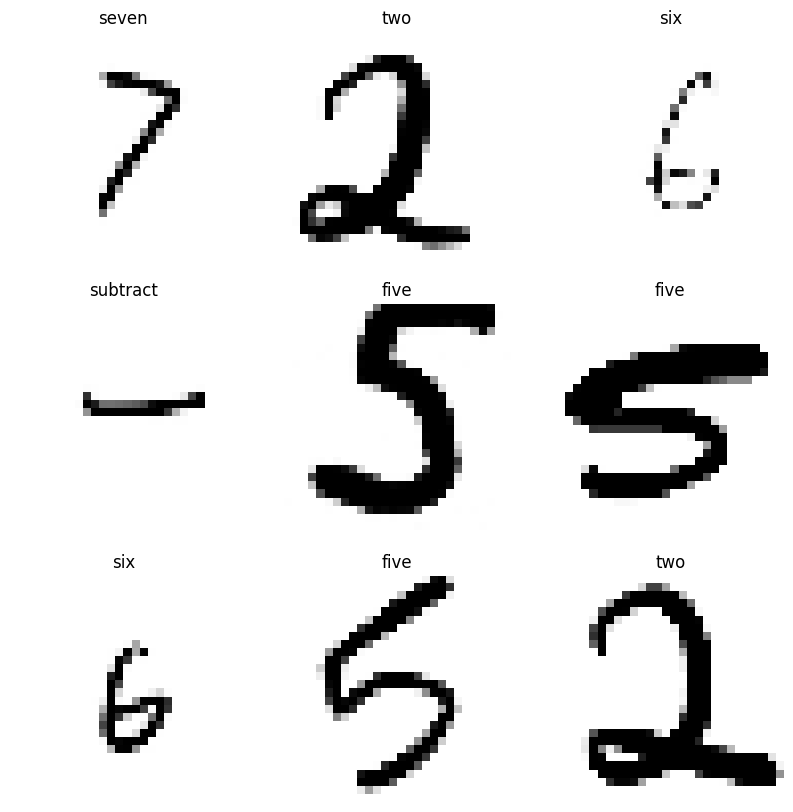

In [46]:


plt.figure(figsize=(10, 10)) # Creating a figure
for images, labels in val_dataset.take(1): # takes one batch of data from the train_dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1) # Creates a subplot in a 3x3 grid and places the next image in the i+1 position.
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        # .numpy(): Converts the TensorFlow tensor to a NumPy array for compatibility with Matplotlib
        # .squeeze(): Removes single-dimensional entries ( if the image is shaped (height, width, 1), it becomes (height, width) )
        # cmap='gray': Displays the image in grayscale mode
        plt.title(class_names[labels[i]]) # Sets the title of each subplot to the class name corresponding to the label of the i-th image.
        plt.axis('off') # Hides the axis for a cleaner visualization.
plt.show() #  Renders and displays the plotted figure

# To be clear, the grid with the images is just for me as a devveloper to view. To make sure everything looks and works as expected

##  Building the Model

### Import from keras

In [35]:
from keras import Sequential, Input
from keras.api.layers import *

### Construct the model

This sequential model has multiple layers that process the image data step by step.

In [60]:
model = Sequential([
    Input(shape=(img_height, img_width, 1)),
    # (img_height, img_width, 1) specifies the height and width of the input image and the number of channels. 1 indicates grayscale images
    Conv2D(32, (3, 3), activation='relu'),
    # This layer applies 32 filters (or kernels) to the input image
    # (3, 3): Each filter is a 3x3 matrix, sliding over the image and detecting specific patterns, like edges.
    # relu: ReLU (Rectified Linear Unit) introduces non-linearity, which helps the network learn complex patterns.
    MaxPooling2D(pool_size=(2, 2)),
    # Pooling Size (2, 2): This layer takes the maximum value in each 2x2 window, reducing the spatial dimensions by half.
    # For example, if the input to this layer is (28, 28), the output will be (14, 14)

    # The purpose is to help this layer reduce the amount of computation and helps the model focus on the most important features.
    Conv2D(64, (3, 3), activation='relu'),
    # Similar to the first Conv2D layer, but with 64 filters. As the network goes deeper,
    # the number of filters usually increases to capture more complex patterns.
    MaxPooling2D(pool_size=(2, 2)),
    # This layer further reduces the spatial dimensions by half again, reducing the overall feature map size.
    Flatten(),
    # Converts the 2D feature maps into a 1D vector, making it ready for the fully connected dense layers.
    # The resulting 1D vector is passed to dense layers for classification.
    Dense(128, activation='relu'),
    # 128 Units: This layer has 128 neurons, each fully connected to the previous layer
    # Like before, the ReLU function allows the model to learn more complex patterns by introducing non-linearity.

    Dense(14, activation='softmax')
    # The number of neurons matches the number of classes in the dataset. 0-9 / * + - == 14
    # The Softmax activation function converts the output to probabilities,
    # where each class has a probability score that adds up to 1. This is suitable for multi-class classification.
])

### Compiling the Model

In [61]:
model.compile(
    optimizer='adam',
    # The Adam optimizer adjusts the model's weights to minimize the loss function.
    # It’s adaptive, efficient, and commonly used for deep learning tasks.
    loss='sparse_categorical_crossentropy',
    # The loss function measures the difference between the true labels and the predicted probabilities
    # The reason sparse is used, is because the labels are integers ( 0, 1, 2, etc ) instead of one-hot encoded vectors
    metrics=['accuracy']
    # This tracks the accuracy during training and evaluation, showing the proportion of correct predictions.
)

## Train the Model

Training Dataset: helps the model learn patterns in the data.

Validation Dataset: assesses how well the model generalizes to unseen data, acting as a quality check against overfitting.

Epochs: control the training duration, affecting the balance between underfitting and overfitting.

In [62]:
history = model.fit(
    train_dataset,
    # The training dataset is the main set of data used by the model to learn the relationships between inputs and outputs.
    validation_data=val_dataset,
    # Using a validation dataset helps to prevent overfitting by allowing to monitor the model’s performance on data it hasn’t seen before.
    # After each epoch, the model evaluates its performance on the validation dataset,
    # giving an indication of how well it is generalizing to unseen data
    epochs=5 
    # With each epoch, the model updates its weights to reduce the loss based on the training data,
    # ideally improving its accuracy and generalization
)

Epoch 1/5
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6426 - loss: 2.9685 - val_accuracy: 0.0849 - val_loss: 2.6356
Epoch 2/5
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9218 - loss: 0.2558 - val_accuracy: 0.0808 - val_loss: 2.6390
Epoch 3/5
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9492 - loss: 0.1647 - val_accuracy: 0.0808 - val_loss: 2.6469
Epoch 4/5
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9594 - loss: 0.1277 - val_accuracy: 0.0808 - val_loss: 2.6517
Epoch 5/5
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9639 - loss: 0.1154 - val_accuracy: 0.0808 - val_loss: 2.6738


## Accuracy and loss over epochs to check for signs of overfitting <------------

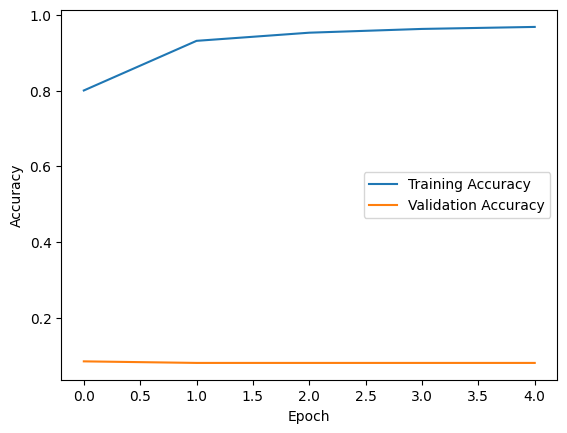

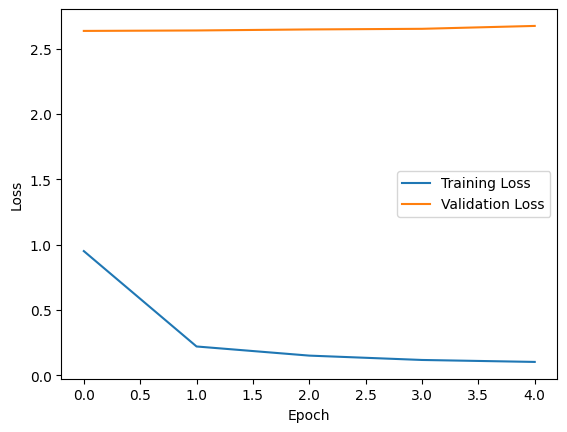

In [63]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()